# ULMFiT + Siamese Network for Sentence Vectors
## Part Three: Classifying

The second notebook created a new language model from the SNLI dataset.
This notebook will adapt that model to predicting the SNLI category for sentence pairs.
The model will be used as a sentence encoder for a Siamese Network that builds sentence vectors that are feed into a classifier network.

In [1]:
import fastai
from fastai.text import *
import html

import json
import html
import re
import pickle
from collections import Counter
import random
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn
from sklearn import model_selection
from functools import partial
from collections import Counter, defaultdict
import random

import numpy as np
import torch
import torch.nn as nn
import torch.utils 
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import dataset, dataloader
import torch.optim as optim
import torch.nn.functional as F

import time
import math
import sys
import data

snli_root = './data/snli_1.0/'
token_files = './data/tokens/'

## Create a new dataloader to create sentence pairs

In [2]:
class SiameseDataLoader():
    def __init__(self, sentence_pairs, pad_val, batch_size=32):
        self.sentence_pairs = sentence_pairs
        self.batch_size = batch_size
        self.index = 0
        self.pad_val = pad_val
     
    def shuffle(self):
        def srtfn(x):
            return x[:, -1] + random.randint(-5, 5)
        
        order = np.argsort(srtfn(self.sentence_pairs))
        self.sentence_pairs = self.sentence_pairs[order]
        
    def __iter__(self):
        return self
    
    def fill_tensor(self, sentences, max_len):
        data = np.zeros((max_len, len(sentences)), dtype=np.long)
        data.fill(self.pad_val)
        
        for i, s in enumerate(sentences): 
            start_idx = max_len - len(s)
            for j, p in enumerate(s):
                data[:,i][start_idx+j] = p
            
        return torch.LongTensor([data.tolist()]).cuda()
     
    def batch(self):
        return self.index//self.batch_size
    
    def __len__(self):
        return len(self.sentence_pairs)//self.batch_size
    
    def __next__(self):
        #how many examples to ananlyise for this round
        num = min(self.batch_size, len(self.sentence_pairs) - self.index)
        
        if num < 1:
            raise StopIteration  # signals "the end"
            
        #collect the sentences
        max_len_a = 0
        max_len_b = 0
        first = []
        second = []
        labels = torch.LongTensor(num)
        
        for i in range(num):
            a, b, l, _ = self.sentence_pairs[self.index + i]
            
            if len(a) > max_len_a:
                max_len_a = len(a)
            
            if len(b) > max_len_b:
                max_len_b = len(b)
            
            first.append(a)
            second.append(b)
            labels[i] = l 
            
        self.index += num
        
        first = self.fill_tensor(first, max_len_a)
        second = self.fill_tensor(second, max_len_b)
        return (first.cuda(),
                (first != self.pad_val).cuda(),
                second.cuda(),
                (second != self.pad_val).cuda(),
                labels.cuda()
               )

In [3]:
itos = pickle.load(open(f'{token_files}itos.pkl', 'rb'))
stoi = defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
vocab_size = len(itos)
pad_tok = stoi['_pad_']

sentence_pairs_train = np.load(f'{token_files}snli_tok_train.npy')
sentence_pairs_dev = np.load(f'{token_files}snli_tok_dev.npy')
sentence_pairs_test = np.load(f'{token_files}snli_tok_test.npy')

def print_sentence(s):
    sentence = ""
    for tok in s:
        sentence += " "+itos[tok]
    print(sentence)

print_sentence(sentence_pairs_train[0][0])
print_sentence(sentence_pairs_train[0][1])

print_sentence(sentence_pairs_dev[0][0])
print_sentence(sentence_pairs_dev[0][1])

print_sentence(sentence_pairs_test[0][0])
print_sentence(sentence_pairs_test[0][1])

 x_bos a person on a horse jumps over a broken down airplane .
 x_bos a person is training his horse for a competition .
 x_bos two women are embracing while holding to go packages .
 x_bos the sisters are hugging goodbye while holding to go packages after just eating lunch .
 x_bos this church choir sings to the masses as they sing joyous songs from the book at a church .
 x_bos the church has cracks in the ceiling .


# Check the dataloader

In [4]:
training_data = SiameseDataLoader(sentence_pairs_train, pad_tok)
for batch in training_data:
    sentences = batch[0][0]
    masks = batch[1][0]
    for sentence, mask in zip(sentences.transpose(1,0), masks.transpose(1,0)):
        for tok in torch.masked_select(sentence, mask):
            print(itos[int(tok)], end=' ')
        print("")
    break

x_bos a person on a horse jumps over a broken down airplane . 
x_bos a person on a horse jumps over a broken down airplane . 
x_bos a person on a horse jumps over a broken down airplane . 
x_bos children smiling and waving at camera 
x_bos children smiling and waving at camera 
x_bos children smiling and waving at camera 
x_bos a boy is jumping on skateboard in the middle of a red bridge . 
x_bos a boy is jumping on skateboard in the middle of a red bridge . 
x_bos a boy is jumping on skateboard in the middle of a red bridge . 
x_bos an older man sits with his orange juice at a small table in a coffee shop while employees in bright colored shirts smile in the background . 
x_bos an older man sits with his orange juice at a small table in a coffee shop while employees in bright colored shirts smile in the background . 
x_bos an older man sits with his orange juice at a small table in a coffee shop while employees in bright colored shirts smile in the background . 
x_bos two blond women 

# Evaluate the masking and pooling code

In [132]:
# sentences are in the form [sentence_length, batch_size, embedding_size]
# masks are in the form [sentence_length, batch_size])
sentence_length = 5
batch_size = 3
embedding_size = 4

out = torch.zeros((batch_size, embedding_size))
sentences = torch.tensor([ 
                    [[1,1,1,1], [4,4,4,4], [7,7,7,7]],
                    [[2,2,2,2], [5,5,5,5], [8,8,8,8]],
                    [[0,0,0,0], [6,6,6,6], [9,9,9,9]],
                    [[0,0,0,0], [0,0,0,0], [10,10,10,10]],
                    [[0,0,0,0], [0,0,0,0], [0,0,0,0]]
                    ]).float()

#sentences.shape == [5, 3, 4]

masks = torch.tensor([[[1,1,1], [1,1,1], [0,1,1], [0,0,1], [0,0,0]]]).byte()
#masks.shape == [1, 5, 3]

for i, sentence, mask in zip(range(batch_size), sentences.permute((1,0,2)), masks.squeeze().permute(1,0)):
    mask = mask.unsqueeze(1)
    selected = torch.masked_select(sentence, mask)
    selected = torch.reshape(selected, (-1, embedding_size))
    print(selected)
    max = torch.max(selected, 0)[0]
    print(max)
    out[i] = torch.mean(selected, 0)
print(out)

tensor([[1., 1., 1., 1.],
        [2., 2., 2., 2.]])
tensor([2., 2., 2., 2.])
tensor([[4., 4., 4., 4.],
        [5., 5., 5., 5.],
        [6., 6., 6., 6.]])
tensor([6., 6., 6., 6.])
tensor([[ 7.,  7.,  7.,  7.],
        [ 8.,  8.,  8.,  8.],
        [ 9.,  9.,  9.,  9.],
        [10., 10., 10., 10.]])
tensor([10., 10., 10., 10.])
tensor([[1.5000, 1.5000, 1.5000, 1.5000],
        [5.0000, 5.0000, 5.0000, 5.0000],
        [8.5000, 8.5000, 8.5000, 8.5000]])


## Siamese network

In [157]:
class SiameseClassifier(nn.Module):
    
    def __init__(self, encoder, linear):
        super().__init__()
        self.encoder = encoder
        self.linear = linear
    
    def pool(self, x, masks, is_max):
        #x.shape = sentence length, batch size, embedding size
        #mask.shape = [1, sentence length, batch size]
        
        embedding_size = x.shape[2]
        batch_size = x.shape[1]
        out = torch.zeros((batch_size, embedding_size)).cuda()
        masks = masks.squeeze()
        #print(f'shapes: x {x.shape}, masks {masks.shape}, out {out.shape}')
        
        #shapes: x torch.Size([7, 32, 400]), mask torch.Size([7, 32]), out torch.Size([32, 400])
                
        for i, hidden, mask in zip(range(batch_size), x.permute((1,0,2)), masks.permute(1,0)):
            mask = mask.unsqueeze(1)
            selected = torch.masked_select(hidden, mask)
            selected = torch.reshape(selected, (-1, embedding_size))
            if is_max:
                max_pool = torch.max(selected, 0)[0]
                out[i] = max_pool
            else:
                mean_pool = torch.mean(selected, 0)
                out[i] = mean_pool

        return out

    def pool_outputs(self, output, mask):
        avgpool = self.pool(output, mask, False)
        maxpool = self.pool(output, mask, True)
        last = output[-1]
        return torch.cat([last, maxpool, avgpool], 1)
        
    def forward_once(self, input, mask):
        raw_outputs, outputs = self.encoder(input)
        out = self.pool_outputs(outputs[-1], mask)
        return out
    
    def forward(self, in1, in1_mask, in2, in2_mask):
        u = self.forward_once(in1, in1_mask)
        v = self.forward_once(in2, in2_mask)
        features = torch.cat((u, v, torch.abs(u-v), u*v), 1)
        out = self.linear(features)
        return out 
        
    def reset(self):
        for c in self.children():
            if hasattr(c, 'reset'): c.reset()

class LinearClassifier(nn.Module):
    def __init__(self, layers, dropout):
        super().__init__()
        self.layers = nn.ModuleList([LinearBlock(layers[i], layers[i + 1], dropout) for i in range(len(layers) - 1)])
        
    def forward(self, input):
        x = input
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return l_x


In [115]:
#these are the values used for the original LM
em_sz, nh, nl = 400, 1150, 3
bptt = 70
max_seq = bptt * 20
cats = 3

## Load our pretrained model then build the Siamese network from it

## Training loop
This should be converted over to the fast.ai learner but I'm not sure how to do that yet.

In [163]:
log_interval = 1000
criterion = nn.CrossEntropyLoss()
#criterion = nn.CosineEmbeddingLoss()

def evaluate(model, data_loader):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    
    total_loss = 0.
    num_correct = 0
    total = 0 
    
    for a, a_mask, b, b_mask, l in data_loader:
        
        model.reset()
        out = model(a.squeeze(), a_mask, b.squeeze(), b_mask)
        loss = criterion(out, l.squeeze())
        total += l.size(0)
        total_loss += l.size(0) * loss.item()
        num_correct += np.sum(l.data.cpu().numpy() == np.argmax(out.data.cpu().numpy(), 1))
        
    return (total_loss / total, num_correct / total)

def train(model, data_loader, optimizer):
    # Turn on training mode which enables dropout.
    start_time = time.time()
    model.train() 
    
    total_loss = 0.
    num_correct = 0
    total = 0 
        
    for a, a_mask, b, b_mask, l in data_loader:
        optimizer.zero_grad()
        
        model.reset()
        #torch.Size([1, 7, 32])
        
        out = model(a.squeeze(), a_mask, b.squeeze(), b_mask)
        loss = criterion(out, l.squeeze())
        total += l.size(0)
        total_loss += l.size(0) * loss.item()
        num_correct += np.sum(l.data.cpu().numpy() == np.argmax(out.data.cpu().numpy(), 1))
        
        loss.backward()
        optimizer.step()

        batch = data_loader.batch()
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / total
            elapsed = time.time() - start_time
            batches = len(data_loader)
            ms = elapsed * 1000 / log_interval
            print(f'| {batch:5d}/{batches:5d} batches', end=" ")
            print(f'| ms/batch {ms:5.2f} | loss {cur_loss:5.4f} acc {num_correct / total}')
            #print(f'| ms/batch {ms:5.2f} | loss {cur_loss:5.4f}')
            total_loss = 0
            total = 0
            num_correct = 0
            start_time = time.time()

In [117]:
best_loss = 100
def training_loop(model, epochs, optimizer, scheduler = None):
    
    global best_loss
    for epoch in range(epochs):

        print(f'Start epoch {epoch:3d} training with lr ', end="")
        for g in optimizer.param_groups:
            print(g['lr'], end=" ")
        print("")
        
        training_data = SiameseDataLoader(sentence_pairs_train, pad_tok)
        training_data.shuffle()

        epoch_start_time = time.time()
        
        train(model, training_data, optimizer)
        if scheduler != None:
            scheduler.step()

        dev_data = SiameseDataLoader(sentence_pairs_dev, pad_tok)
        val_loss, accuracy = evaluate(model, dev_data)

        delta_t = (time.time() - epoch_start_time)
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {delta_t:5.2f}s | valid loss {val_loss:5.2f} accuracy {accuracy} learning rates')
        for g in optimizer.param_groups:
            print(g['lr'])
        print('-' * 89)

        if val_loss < best_loss:
            best_loss = val_loss
            with open(f'./siamese_model{val_loss:0.2f}{accuracy:0.2f}.pt', 'wb') as f:
                torch.save(siamese_model, f)

In [9]:
from scipy.signal import butter, filtfilt
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def plot_loss(losses):
    plt.semilogx(losses[:,0], losses[:,1])
    plt.semilogx(losses[:,0], butter_lowpass_filtfilt(losses[:,1], 300, 5000))
    plt.show()

def find_lr(model, model_to_optim, data_loader):
    losses = []
    model.train() 
    criterion = nn.CrossEntropyLoss()
    lr = 0.00001
    for a, b, l in data_loader:
        optimizer = optim.SGD(model_to_optim.parameters(), lr=lr)
        #optimizer = optim.Adam(model_to_optim.parameters(), lr=lr)
        optimizer.zero_grad()
        
        model.reset()
        a, b, l = Variable(a), Variable(b), Variable(l)
        out = model(a.squeeze(), b.squeeze())
        loss = criterion(out, l.squeeze())
        
        los_val = loss.item()
        losses.append((lr, los_val))
        if los_val > 5:
            break
        
        loss.backward()
        optimizer.step()
        
        lr *= 1.05
    losses = np.array(losses)
    #plot_loss(losses)
    return losses

In [149]:
SNLI_LM = torch.load("snli_language_model.pt")

dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.4
SNLI_encoder = MultiBatchRNN(bptt, max_seq, vocab_size, em_sz, nh, nl, pad_tok, dropouti=dps[0], wdrop=dps[2], dropoute=dps[3], dropouth=dps[4])

SNLI_encoder.load_state_dict(SNLI_LM[0].state_dict())

#2 pooled vectors, of 3 times the embedding size
siamese_model = SiameseClassifier(SNLI_encoder, LinearClassifier(layers=[em_sz*3*4, nh, 3], dropout=0.4)).cuda()

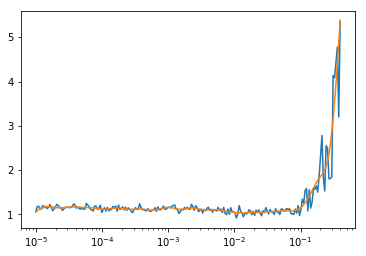

In [12]:
dev_data = SiameseDataLoader(sentence_pairs_dev, pad_tok)
losses = find_lr(siamese_model, siamese_model, dev_data)
plot_loss(np.array(losses))

In [ ]:
for param in siamese_model.encoder.parameters():
    param.requires_grad = False

optimizer = optim.SGD(siamese_model.linear.parameters(), lr=0.001)
training_loop(siamese_model, 1, optimizer)

In [158]:
siamese_model = torch.load("./siamese_model0.500.81.pt")

In [ ]:
for param in siamese_model.encoder.parameters():
    param.requires_grad = True

for lr in [x/200+0.005 for x in range(20)]:
    optimizer = optim.SGD(siamese_model.parameters(), lr=lr)
    training_loop(siamese_model, 1, optimizer)

In [164]:
epochs = 10
optimizer = optim.SGD(siamese_model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0.001)
training_loop(siamese_model, epochs, optimizer, scheduler)

Start epoch   0 training with lr 0.1 
|  1000/17167 batches | ms/batch 67.67 | loss 0.5281 acc 0.78715625
|  2000/17167 batches | ms/batch 69.79 | loss 0.5387 acc 0.78325
|  3000/17167 batches | ms/batch 70.89 | loss 0.5480 acc 0.77896875
|  4000/17167 batches | ms/batch 71.97 | loss 0.5530 acc 0.776
|  5000/17167 batches | ms/batch 72.79 | loss 0.5536 acc 0.77640625
|  6000/17167 batches | ms/batch 73.80 | loss 0.5588 acc 0.77115625
|  7000/17167 batches | ms/batch 74.65 | loss 0.5693 acc 0.76546875
|  8000/17167 batches | ms/batch 75.68 | loss 0.5699 acc 0.76525
|  9000/17167 batches | ms/batch 76.51 | loss 0.5815 acc 0.7599375
| 10000/17167 batches | ms/batch 77.59 | loss 0.5723 acc 0.766
| 11000/17167 batches | ms/batch 78.65 | loss 0.5753 acc 0.763375
| 12000/17167 batches | ms/batch 80.16 | loss 0.5749 acc 0.7624375
| 13000/17167 batches | ms/batch 81.62 | loss 0.5837 acc 0.75634375
| 14000/17167 batches | ms/batch 83.44 | loss 0.5935 acc 0.754
| 15000/17167 batches | ms/batch 85

/home/brian/.conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/brian/.conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


|  1000/17167 batches | ms/batch 67.74 | loss 0.5280 acc 0.79215625
|  2000/17167 batches | ms/batch 69.76 | loss 0.5331 acc 0.783125
|  3000/17167 batches | ms/batch 70.89 | loss 0.5482 acc 0.7763125
|  4000/17167 batches | ms/batch 71.98 | loss 0.5508 acc 0.77615625
|  5000/17167 batches | ms/batch 73.01 | loss 0.5534 acc 0.7758125
|  6000/17167 batches | ms/batch 73.85 | loss 0.5528 acc 0.7736875
|  7000/17167 batches | ms/batch 74.70 | loss 0.5596 acc 0.7705625
|  8000/17167 batches | ms/batch 75.68 | loss 0.5618 acc 0.77025
|  9000/17167 batches | ms/batch 76.59 | loss 0.5787 acc 0.76225
| 10000/17167 batches | ms/batch 77.65 | loss 0.5624 acc 0.76890625
| 11000/17167 batches | ms/batch 78.97 | loss 0.5723 acc 0.76221875
| 12000/17167 batches | ms/batch 80.44 | loss 0.5766 acc 0.7605
| 13000/17167 batches | ms/batch 81.60 | loss 0.5815 acc 0.75878125
| 14000/17167 batches | ms/batch 83.55 | loss 0.5871 acc 0.7581875
| 15000/17167 batches | ms/batch 85.63 | loss 0.5888 acc 0.754406

In [12]:
entailed_a = []
entailed_b = []
contra_a = []
contra_b = []
netural_a = []
netural_b = []

In [18]:
for a,b,l,_ in sentence_pairs_dev:
    if l == 0:
        #entailed
        entailed_a.append(a)
        entailed_b.append(b)
    elif l == 1:
        contra_a.append(a)
        contra_b.append(b)
    else:
        netural_a.append(a)
        netural_b.append(b)

In [22]:
def make_prediction_from_list(model, l):
    """
    Encode a list of integers that represent a sequence of tokens.  The
    purpose is to encode a sentence or phrase.

    Parameters
    -----------
    model : fastai language model
    l : list
        list of integers, representing a sequence of tokens that you want to encode`

    """
    arr = torch.tensor(np.expand_dims(np.array(l), -1)).cuda()
    model.reset()  # language model is stateful, so you must reset upon each prediction
    hidden_states = model(arr)[-1][-1] # RNN Hidden Layer output is last output, and only need the last layer

    #return avg-pooling, max-pooling, and last hidden state
    return hidden_states.mean(0), hidden_states.max(0)[0], hidden_states[-1]

def get_embeddings(encoder, list_list_int):
    """
    Vectorize a list of sequences List[List[int]] using a fast.ai language model.

    Paramters
    ---------
    encoder : sentence_encoder
    list_list_int : List[List[int]]
        A list of sequences to encode

    Returns
    -------
    tuple: (avg, mean, last)
        A tuple that returns the average-pooling, max-pooling over time steps as well as the last time step.
    """
    n_rows = len(list_list_int)
    n_dim = encoder.nhid
    avgarr = np.empty((n_rows, n_dim))
    maxarr = np.empty((n_rows, n_dim))
    lastarr = np.empty((n_rows, n_dim))

    for i in range(len(list_list_int)):
        avg_, max_, last_ = make_prediction_from_list(encoder, list_list_int[i])
        avgarr[i,:] = avg_.data.cpu().numpy()
        maxarr[i,:] = max_.data.cpu().numpy()
        lastarr[i,:] = last_.data.cpu().numpy()

    return avgarr, maxarr, lastarr


In [21]:
siamese_model = torch.load('siamese_model0.500.81.pt')
siamese_model.encoder.nhid = 400

In [24]:
entailed_a_vec = get_embeddings(siamese_model.encoder, entailed_a)
entailed_b_vec = get_embeddings(siamese_model.encoder, entailed_b)

In [105]:
import nmslib

def create_nmslib_search_index(numpy_vectors):
    """Create search index using nmslib.
    Parameters
    ==========
    numpy_vectors : numpy.array
        The matrix of vectors
    Returns
    =======
    nmslib object that has index of numpy_vectors
    """

    search_index = nmslib.init(method='hnsw', space='cosinesimil')
    search_index.addDataPointBatch(numpy_vectors)
    search_index.createIndex({'post': 2}, print_progress=True)
    return search_index

def percent_matching(query_vec, searchindex, k=10):
    num_found = 0
    num_total = len(query_vec)
    for i in range(num_total):
        query = query_vec[i]
        idxs, dists = searchindex.knnQuery(query, k=k)
        if i in idxs:
            num_found += 1

    return 100 * num_found/num_total

def indexes_matching(query_vec, search_index, k=5):
    results = []
    for q in query_vec:
        index_set = set()
        idxs, dists = search_index.knnQuery(q, k=k)
        results.append(idxs)
    return results
 
def percent_found(results):
    num_found = 0
    for i, result in enumerate(results):
        if i in result:
            num_found += 1
    return (num_found/len(results))

def decode_sentence(sentence):
    result = ""
    for word_idx in sentence: 
        result += f"{itos[word_idx]} "
        
    return result
    
def show_similar(query_idx, matched):
    print(decode_sentence(entailed_a[query_idx]))
    for idx in matched:
        print(f"\t{decode_sentence(entailed_b[idx])}")
    print("")

In [101]:
entailed_b_avg_searchindex = create_nmslib_search_index(entailed_b_vec[0])
entailed_b_max_searchindex = create_nmslib_search_index(entailed_b_vec[1])
entailed_b_last_searchindex = create_nmslib_search_index(entailed_b_vec[2])

In [102]:
results_avg = indexes_matching(entailed_a_vec[0], entailed_b_avg_searchindex, 3)
results_max = indexes_matching(entailed_a_vec[1], entailed_b_max_searchindex, 3)
results_last = indexes_matching(entailed_a_vec[2], entailed_b_last_searchindex, 3)

num_found = 0
for i in range(len(results_avg)):
    if i in results_avg[i] or i in results_max[i] or i in results_last[i]:
        num_found += 1
print(num_found/len(results_avg))

0.5013517572844698


In [103]:
results_combined = []
for a,b,c in zip(results_avg, results_max, results_last):
    results_combined.append(set(a).union(set(b).union(set(c))))

In [106]:
for i, r in enumerate(results_combined):
    show_similar(i, r)

x_bos two women are embracing while holding to go packages . 
	x_bos two woman are holding packages . 
	x_bos there are three girls and one boy waiting for the school bus . 
	x_bos women are holding a flag 
	x_bos a young male is looking at a newspaper while 2 females walks past him . 
	x_bos man and woman stop and chat with each other . 
	x_bos women are holding hands . 
	x_bos the girls are holding hands . 
	x_bos the bus already has people waiting on it . 

x_bos two young children in blue jerseys , one with the number 9 and one with the number 2 are standing on wooden steps in a bathroom and washing their hands in a sink . 
	x_bos two kids in numbered jerseys wash their hands . 
	x_bos a baby is dressed in a bathrobe waiting for a shower . 
	x_bos a caucasian man plays with his hair in the shower . 
	x_bos four young people are lined up behind another and they are holding their arms out so it looks like the arms all belong to the first person , a red haired woman in a bikini top . 

In [107]:
siamese_model = torch.load('siamese_model0.500.81.pt')

In [109]:
torch.save(siamese_model.encoder.state_dict(), "siamese_encoder_dict.pt")